# Module 5 HW

### Part 1 - Splitting the Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

# Loading the dataset
radar_params = pd.read_csv('homework/radar_parameters.csv')

# Dropping the first index column
radar_params = radar_params.iloc[:, 1:]

# Quick check (looks good - same as what's in the hw.md file)
radar_params.head()

,Zh (dBZ),Zdr (dB),Ldr (dB),Kdp (deg km-1),Ah (dBZ/km),Adr (dB/km),R (mm/hr)
0,23.144878,0.418637,-41.757733,0.005395,0.000290,0.000012,2.393520
1,22.737156,0.322850,-43.772069,0.005194,0.000360,0.000012,3.502699
2,26.869826,0.330948,-43.577399,0.013385,0.000903,0.000030,8.627561
3,28.540561,0.399480,-42.139731,0.018872,0.001036,0.000043,8.424447
4,30.500127,0.543758,-39.763087,0.027438,0.001157,0.000064,8.189291


c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


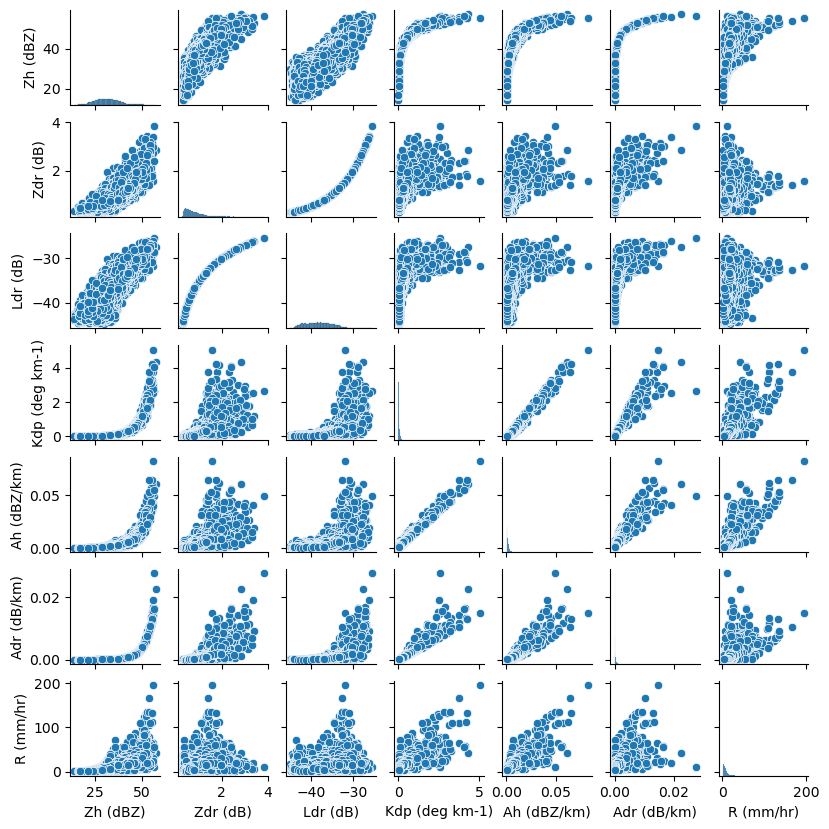

In [2]:
# Making a pairplot because I like the quick visual
sns.pairplot(radar_params, size=1.2)


In [3]:
# Splitting the data
from sklearn.model_selection import train_test_split

X_radar = radar_params.drop(columns=['R (mm/hr)'])
Y_radar = radar_params['R (mm/hr)']

X_train, X_test, Y_train, Y_test = train_test_split(X_radar, Y_radar,
                                                test_size=0.30, random_state=1)


### Part 2

Using the split to train a lin reg model.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error

# Selecting Lin Reg for the model (fitting to an intercept)
model = LinearRegression(fit_intercept=True)

# Adding in the fit
model.fit(X_train, Y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [5]:
# Printing parameters
model.coef_

array([ 1.56083631e-01,  2.02362488e+00, -6.20516403e-01, -7.07332731e+01,
        7.79391975e+03, -6.17735608e+03])

In [6]:
model.intercept_

np.float64(-29.2149525456034)

In [7]:
# Generating the predictions
Y_train_pred = model.predict(X_train) 
Y_test_pred = model.predict(X_test)

# Printing stats for both training and test predictions
print("Training Data R2 = ", r2_score(Y_train,Y_train_pred))
print("Training Data RMSE = ", root_mean_squared_error(Y_train,Y_train_pred))
print("Test Data R2 = ", r2_score(Y_test,Y_test_pred))
print("Test Data RMSE = ", root_mean_squared_error(Y_test,Y_test_pred))

Training Data R2 =  0.9876962938881576
Training Data RMSE =  0.9411927035424521
Test Data R2 =  0.9896313936002781
Test Data RMSE =  0.8922106275440651


Test data looks like it fits rather well, especially given lower RMSE than the training data.

Comparing with the theoretical formula Z=200*R^1.6 next.

In [8]:
# Unit convervsion from dBZ to Z (Z = 10^(dBz/10))
Z_train = 10 ** ( X_train["Zh (dBZ)"] / 10 ) 
Z_test = 10 ** ( X_test["Zh (dBZ)"] / 10 ) 

# Calculate Theoretical R values
R_train = ( Z_train / 200 ) ** ( 1 / 1.6 )
R_test = ( Z_test / 200 ) ** ( 1 / 1.6 )

print("Theoretical R and Training Data R2 = ", r2_score(Y_train,R_train))
print("Theoretical R and Training Data RMSE = ", root_mean_squared_error(Y_train,R_train))
print("Theoretical R and Test Data R2 = ", r2_score(Y_test,R_test))
print("Theoretical R and Test Data RMSE = ", root_mean_squared_error(Y_test,R_test))

Theoretical R and Training Data R2 =  0.2851359692537384
Theoretical R and Training Data RMSE =  7.174180513738772
Theoretical R and Test Data R2 =  0.3399282314234663
Theoretical R and Test Data RMSE =  7.118734189050042


It looks like the theoretical formula is a much worse fit than the linear regression model. Lower R^2 and higher RMSE.

### Part 3

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Setting up the pipeline for polynomial + lin reg

pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures()),
                 ('linearregression', LinearRegression())
                ])
# Making the parameter grid
param_grid = {'polynomialfeatures__degree': np.arange(10),
              'linearregression__fit_intercept': [True, False]}

# This was SLOW on my old laptop, so I did some googling and found out that setting n_jobs to -1 uses more cores.
# That made it slightly faster, but not much
grid = GridSearchCV(pipeline, param_grid, cv=7, scoring="r2", n_jobs=-1)

# Fitting the grid with the training data
grid.fit(X_train,Y_train)

# Printing the best fitting parameters
grid.best_params_

{'linearregression__fit_intercept': True,
 'polynomialfeatures__degree': np.int64(8)}

The best fit is a 8th order polynomial with an intercept.

In [17]:
# Comparing with the linear model from above

# Predict with the best polynomial on both splits
best_poly_model = grid.best_estimator_
Y_train_pred_poly = best_poly_model.predict(X_train)
Y_test_pred_poly  = best_poly_model.predict(X_test)

# Printing comparison results for both training + test data
print("Best Fit Poly Model vs Training Data R2 = ", r2_score(Y_train,Y_train_pred_poly))
print("Best Fit Poly Model vs Training Data RMSE = ", root_mean_squared_error(Y_train,Y_train_pred_poly))
print("Best Fit Poly Model vs Test Data R2 = ", r2_score(Y_test,Y_test_pred_poly))
print("Best Fit Poly Model vs Test Data RMSE = ", root_mean_squared_error(Y_test,Y_test_pred_poly))

print("Linear Model vs Training Data R2 = ", r2_score(Y_train,Y_train_pred))
print("Linear Model vs Training Data RMSE = ", root_mean_squared_error(Y_train,Y_train_pred))
print("Linear Model vs Test Data R2 = ", r2_score(Y_test,Y_test_pred))
print("Linear Model vs Test Data RMSE = ", root_mean_squared_error(Y_test,Y_test_pred))

Best Fit Poly Model vs Training Data R2 =  0.9999995827341955
Best Fit Poly Model vs Training Data RMSE =  0.005481090523629036
Best Fit Poly Model vs Test Data R2 =  0.9999982634144498
Best Fit Poly Model vs Test Data RMSE =  0.011546631055747651
Linear Model vs Training Data R2 =  0.9876962938881576
Linear Model vs Training Data RMSE =  0.9411927035424521
Linear Model vs Test Data R2 =  0.9896313936002781
Linear Model vs Test Data RMSE =  0.8922106275440651


The poly model is a much better fit, with higher r^2 and lower RMSE when compared with both the training and test data.

### Part 4

In [18]:
# Repeating with a random forest regressor
from sklearn.ensemble import RandomForestRegressor

rfr_pipeline = Pipeline([('randomforestregressor', RandomForestRegressor())])

# Setting up paramater grid
param_grid = {
    "randomforestregressor__bootstrap": [True, False],
    "randomforestregressor__max_depth": [10, 100],
    "randomforestregressor__max_features": ["sqrt", 1.0],  
    "randomforestregressor__min_samples_leaf": [1, 4],
    "randomforestregressor__min_samples_split": [2, 10],
    "randomforestregressor__n_estimators": [200, 1000]}

grid_rfr = GridSearchCV(rfr_pipeline, param_grid, cv=7, scoring="r2", n_jobs=-1)

# Fitting the grid with the training data
grid_rfr.fit(X_train,Y_train)

# Printing the best fitting parameters
grid_rfr.best_params_


{'randomforestregressor__bootstrap': False,
 'randomforestregressor__max_depth': 100,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__n_estimators': 200}

In [19]:
# Comparing with the all the models from above

# Predict with the best polynomial on both splits
best_rfr_model = grid_rfr.best_estimator_
Y_train_pred_rfr = best_rfr_model.predict(X_train)
Y_test_pred_rfr  = best_rfr_model.predict(X_test)

# Printing comparison results for both training + test data
print("Best Fit RFR Model vs Training Data R2 = ", r2_score(Y_train,Y_train_pred_rfr))
print("Best Fit RFR Model vs Training Data RMSE = ", root_mean_squared_error(Y_train,Y_train_pred_rfr))
print("Best Fit RFR Model vs Test Data R2 = ", r2_score(Y_test,Y_test_pred_rfr))
print("Best Fit RFR Model vs Test Data RMSE = ", root_mean_squared_error(Y_test,Y_test_pred_rfr))

print("Best Fit Poly Model vs Training Data R2 = ", r2_score(Y_train,Y_train_pred_poly))
print("Best Fit Poly Model vs Training Data RMSE = ", root_mean_squared_error(Y_train,Y_train_pred_poly))
print("Best Fit Poly Model vs Test Data R2 = ", r2_score(Y_test,Y_test_pred_poly))
print("Best Fit Poly Model vs Test Data RMSE = ", root_mean_squared_error(Y_test,Y_test_pred_poly))

print("Linear Model vs Training Data R2 = ", r2_score(Y_train,Y_train_pred))
print("Linear Model vs Training Data RMSE = ", root_mean_squared_error(Y_train,Y_train_pred))
print("Linear Model vs Test Data R2 = ", r2_score(Y_test,Y_test_pred))
print("Linear Model vs Test Data RMSE = ", root_mean_squared_error(Y_test,Y_test_pred))

Best Fit RFR Model vs Training Data R2 =  1.0
Best Fit RFR Model vs Training Data RMSE =  3.139601005639151e-14
Best Fit RFR Model vs Test Data R2 =  0.9861264171857175
Best Fit RFR Model vs Test Data RMSE =  1.0320518416412863
Best Fit Poly Model vs Training Data R2 =  0.9999995827341955
Best Fit Poly Model vs Training Data RMSE =  0.005481090523629036
Best Fit Poly Model vs Test Data R2 =  0.9999982634144498
Best Fit Poly Model vs Test Data RMSE =  0.011546631055747651
Linear Model vs Training Data R2 =  0.9876962938881576
Linear Model vs Training Data RMSE =  0.9411927035424521
Linear Model vs Test Data R2 =  0.9896313936002781
Linear Model vs Test Data RMSE =  0.8922106275440651


Overall the RFR model fits worse than the Poly model but better than the linear model. The R^2 is a small amount lower than the poly model on the test data and has a significantly higher RMSE. 